In [2]:
import matplotlib
%matplotlib inline
from pylab import *
import caesar
import h5py, os, sys
import yt, pickle
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic as bst
from scipy.stats import binned_statistic_2d as bst2
from scipy.signal import savgol_filter as sgf

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

safecolor={
    'silver':"#c0c0c0",
    'gray':"#808080",
    'black':"#000000",
    'red':"#ff0000",
    'maroon':"#800000",
    'yellow':"#ffff00",
    'olive':"#707030",
    'lime':"#00ee00",
    'green':"#009000",
    'aqua':"#00eeee",
    'teal':"#00a0a0",
    'blue':"#0000ff",
    'nave':"#000080",
    'fuchsia':"#ff00ff",
    'purple':"#900090"
}

from matplotlib.ticker import ScalarFormatter

from astropy.cosmology import FlatLambdaCDM
cosm = FlatLambdaCDM(H0=67.77, Om0=0.307115)

(cosm.H0/cosm.H(0.6))**0.06

/home2/weiguang/.local/lib/python3.8/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home2/weiguang/.config/yt/ytrc is deprecated in favor of /home2/weiguang/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


<Quantity 0.980152>

In [49]:
# load data
Music = np.load("../Halo_mass_function_mass-difference/MUSIC/Music_Mass_snap_017_info.npy")
G3X = np.load("../Halo_mass_function_mass-difference/GadgetX/G3X_Mass_snap_128info.npy")
GIZMO=np.load('../Halo_mass_function_mass-difference/GIZMO/GS_Mass_snap_128info.npy')
#ReginIDs HIDs  HosthaloID Mvir(4) Xc(6)   Yc(7)   Zc(8)  Rvir(12) fMhires(38) cNFW (42) Mgas200 M*200 M500  R500 fgas500 f*500

In [50]:
# observation data  comparison to z<~0.1 clusters (Abell 2984 and S84 from Sanderson13 is at z~0.1)
# load observational data
Gon13=np.loadtxt("../theoretical-check/baryonic-fraction-M500/Gonzalez2013_t6_t7.txt",skiprows=5,usecols=([4,5,12,13,14,15]))
Gon500=Gon13[:,0]*10.**14
Gonmerr=np.array([Gon13[:,0]-Gon13[:,1],Gon13[:,0]+Gon13[:,1]])
Gonmerr=np.log10(Gonmerr*1.0e14)-np.log10(Gon500)

Zhang11=np.loadtxt("../theoretical-check/baryonic-fraction-M500/ZhangYY2011.txt",usecols=([2,3,8,9,10,11])) # M500 +- fgas +- f* +-
Zhang500 = Zhang11[:,0]*10.**14
Zhmerr=np.array([Zhang11[:,0]-Zhang11[:,1],Zhang11[:,0]+Zhang11[:,1]])
Zhmerr=np.log10(Zhmerr*1.0e14) - np.log10(Zhang500)

Sanderson13=np.loadtxt("../theoretical-check/baryonic-fraction-M500/Sanderson2013_t3_t4.txt",skiprows=2,usecols=([3,4,11,12,17,18]))
Sanderson13[:,0:2] = Sanderson13[:,0:2]*1.0e14

Krovstov18=np.loadtxt("../theoretical-check/baryonic-fraction-M500/KRAVTSOV2018.txt", usecols=([2,9,10,11,12,13,14]))
Krovstov18[:,0]*=1.0e14
Krovstov18[:,1:]*=1.0e12

Lagana11=np.loadtxt('../theoretical-check/baryonic-fraction-M500/Lagana2011.txt',usecols=([8,9,12,13,14,15]))
Lagana11[:,0:2]*=1.0e14
###Other date!!

Akino21=np.loadtxt('./data/bestfit_HSCXXL.txt')
# MtrueE(z) MsE(z) MsE(z)_p MsE(z)_m MgE(z) MgE(z)_p MgE(z)_m MbcgE(z) MbcgE(z)_p MbcgE(z)_m

In [43]:
Lagana11[0]

array([5.68e+14, 8.10e+13, 7.10e-01, 1.22e-02, 2.20e-03, 1.44e-01])

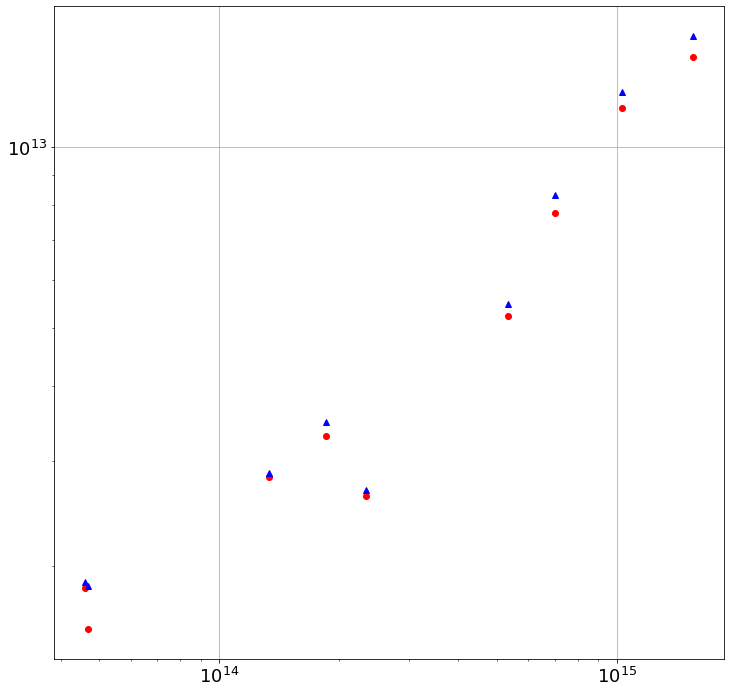

In [22]:
figure(figsize=(12,12))
plot(Krovstov18[:,0],Krovstov18[:,1]+Krovstov18[:,5],'ro')
plot(Krovstov18[:,0],Krovstov18[:,3]+Krovstov18[:,5],'b^')
xscale('log'),yscale('log')
grid()

In [15]:
#vdB 2014 M200 10^14, M*500 10^12 -- M500 = M200*0.631  z~1
vdB2014=np.array([
    [2.4, -1.0, -1.2, 2.10, 0.14, -0.14],
    [2.5, -0.9, -1.0, 1.50, 0.18, -0.16],
    [2.9, -1.0, -0.9, 2.74, 0.14, -0.13],
    [1.7, -1.1, -0.8, 1.55, 0.15, -0.14],
    [1.9, -0.7, -0.9, 0.94, 0.09, -0.08],
    [0.8, -0.2, -0.4, 0.60, 0.06, -0.06],
    [16.9,-4.0, -3.5, 5.68, 0.42, -0.39],
    [1.9, -0.7, -0.8, 2.75, 0.16, -0.15],
    [2.9, -0.7, -1.0, 1.38, 0.11, -0.10],
    [0.6, -0.2, -0.3, 0.92, 0.13, -0.11]
])

In [6]:
# Chiu et al. 2018
Name coord R500[arcmin] M500[1014Msun] M_ICM[1013Msun] M_*[1012Msun] M_b[1013Msun] fc
SPT-CL J0000−5748 2.07 4.13±0.59 3.99±0.23 3.34±0.51 4.33±0.24 0.077±0.012
SPT-CL J0013−4906 3.46 5.94±0.78 6.77±0.19 3.37±0.58 7.11±0.20 0.047±0.008
SPT-CL J0014−4952 2.07 4.74±0.66 6.69±0.15 4.76±0.74 7.17±0.17 0.066±0.010
SPT-CL J0033−6326 2.35 4.30±0.64 4.88±0.16 4.44±0.78 5.32±0.18 0.083±0.014
SPT-CL J0037−5047 1.56 3.73±0.59 2.35±0.19 2.74±0.61 2.62±0.20 0.104±0.022
SPT-CL J0040−4407 4.33 8.25±1.00 8.34±0.26 4.69±0.63 8.81±0.26 0.053±0.007
SPT-CL J0058−6145 1.85 4.06±0.61 4.42±0.15 3.08±0.58 4.73±0.16 0.065±0.012
SPT-CL J0102−4603 2.04 4.16±0.64 4.04±0.14 4.82±0.56 4.52±0.15 0.107±0.012
SPT-CL J0102−4915 2.52 11.36±1.34 22.50±0.21 9.80±1.01 23.48±0.24 0.042±0.004
SPT-CL J0123−4821 2.25 4.09±0.65 4.58±0.09 4.50±0.58 5.03±0.11 0.090±0.011
SPT-CL J0142−5032 2.15 5.02±0.68 5.55±0.27 3.64±0.62 5.92±0.28 0.061±0.010
SPT-CL J0151−5954 1.58 3.91±0.59 5.07±0.14 4.58±0.73 5.52±0.16 0.083±0.012
SPT-CL J0156−5541 1.38 3.49±0.55 4.17±0.15 2.01±0.36 4.37±0.16 0.046±0.008
SPT-CL J0200−4852 2.67 4.31±0.65 5.00±0.17 4.39±0.61 5.44±0.18 0.081±0.011
SPT-CL J0212−4657 2.33 5.15±0.69 6.43±0.22 3.37±0.62 6.77±0.23 0.050±0.009
SPT-CL J0217−5245 3.46 4.01±0.66 4.99±0.13 4.49±0.85 5.44±0.16 0.083±0.014
SPT-CL J0232−5257 2.54 4.71±0.67 5.91±0.21 3.80±0.57 6.29±0.22 0.060±0.009
SPT-CL J0234−5831 3.54 6.70±0.83 7.23±0.20 3.60±0.56 7.59±0.21 0.047±0.007
SPT-CL J0236−4938 3.44 3.69±0.67 3.84±0.07 3.15±0.57 4.15±0.09 0.076±0.013
SPT-CL J0243−5930 2.23 4.18±0.62 5.27±0.16 3.83±0.61 5.66±0.17 0.068±0.010
SPT-CL J0252−4824 3.01 4.24±0.66 4.67±0.14 2.28±0.42 4.89±0.14 0.047±0.008
SPT-CL J0256−5617 2.36 4.15±0.62 5.43±0.13 3.96±0.60 5.83±0.15 0.068±0.010
SPT-CL J0304−4401 3.34 6.99±0.87 9.77±0.24 5.59±0.73 10.33±0.25 0.054±0.007
SPT-CL J0304−4921 3.62 6.26±0.81 7.06±0.14 3.49±0.49 7.41±0.15 0.047±0.006
SPT-CL J0307−5042 2.55 4.64±0.66 5.37±0.14 5.50±0.76 5.92±0.16 0.093±0.012
SPT-CL J0307−6225 2.43 4.49±0.64 5.74±0.20 2.81±0.48 6.02±0.20 0.047±0.008
SPT-CL J0310−4647 2.03 3.98±0.62 4.19±0.23 3.04±0.54 4.49±0.24 0.068±0.012
SPT-CL J0324−6236 2.07 4.46±0.63 4.94±0.13 5.13±0.74 5.45±0.15 0.094±0.012
SPT-CL J0330−5228 3.19 5.63±0.74 11.29±0.18 3.48±0.56 11.64±0.19 0.030±0.005
SPT-CL J0334−4659 2.83 4.85±0.67 5.57±0.14 2.10±0.41 5.78±0.15 0.036±0.007
SPT-CL J0346−5439 2.65 4.82±0.66 5.87±0.14 4.29±0.65 6.30±0.16 0.068±0.010
SPT-CL J0348−4515 3.66 5.27±0.71 5.08±0.17 4.39±0.66 5.52±0.19 0.079±0.011
SPT-CL J0352−5647 2.10 3.90±0.61 4.65±0.16 3.11±0.51 4.96±0.17 0.063±0.010
SPT-CL J0406−4805 2.02 4.21±0.61 5.22±0.17 4.60±0.79 5.68±0.18 0.081±0.013
SPT-CL J0411−4819 3.50 6.79±0.84 9.02±0.13 5.54±0.75 9.58±0.15 0.058±0.007
SPT-CL J0417−4748 2.70 6.23±0.78 7.44±0.20 4.53±0.69 7.89±0.21 0.057±0.008
SPT-CL J0426−5455 2.31 4.58±0.64 5.41±0.14 4.71±0.71 5.88±0.16 0.080±0.011
SPT-CL J0438−5419 3.82 8.68±1.04 11.27±0.22 5.96±0.67 11.87±0.23 0.050±0.005
SPT-CL J0441−4855 1.94 4.31±0.61 4.88±0.12 5.01±0.77 5.38±0.14 0.093±0.013
SPT-CL J0446−5849 1.40 3.50±0.54 2.87±0.31 4.22±0.77 3.29±0.32 0.128±0.024
SPT-CL J0449−4901 1.95 4.41±0.62 4.96±0.16 4.24±0.69 5.39±0.18 0.079±0.012
SPT-CL J0456−5116 2.49 4.51±0.64 5.17±0.09 3.64±0.60 5.53±0.11 0.066±0.010
SPT-CL J0509−5342 2.87 4.51±0.64 5.48±0.16 1.70±0.34 5.65±0.16 0.030±0.006
SPT-CL J0528−5300 1.83 3.45±0.57 2.99±0.10 3.82±0.62 3.37±0.11 0.113±0.017
SPT-CL J0533−5005 1.70 3.60±0.56 2.43±0.15 2.43±0.56 2.67±0.16 0.091±0.020
SPT-CL J0542−4100 2.29 4.65±0.68 5.62±0.13 3.78±0.56 6.00±0.14 0.063±0.009
SPT-CL J0546−5345 1.64 4.58±0.60 6.20±0.15 7.23±0.94 6.92±0.18 0.104±0.012
SPT-CL J0551−5709 3.05 4.45±0.64 6.09±0.11 3.86±0.53 6.47±0.12 0.060±0.008
SPT-CL J0555−6406 4.03 6.43±0.82 8.56±0.19 −− −− −−
SPT-CL J0559−5249 2.44 5.04±0.67 6.99±0.09 5.84±0.79 7.57±0.12 0.077±0.010
SPT-CL J0616−5227 2.06 4.19±0.47 5.02±0.18 6.24±1.26 5.65±0.22 0.111±0.020
SPT-CL J0655−5234 2.83 4.53±0.67 4.42±0.22 −− −− −−
SPT-CL J2031−4037 4.36 7.95±0.97 10.31±0.18 −− −− −−
SPT-CL J2034−5936 1.73 4.08±0.58 5.54±0.13 3.33±0.57 5.87±0.14 0.057±0.009
SPT-CL J2035−5251 2.76 5.39±0.73 5.90±0.19 8.53±0.86 6.76±0.21 0.126±0.012
SPT-CL J2043−5035 2.03 4.17±0.64 5.72±0.10 4.01±0.66 6.12±0.12 0.066±0.010
SPT-CL J2106−5844 1.83 7.14±0.85 10.56±0.21 8.53±1.04 11.41±0.23 0.075±0.009
SPT-CL J2135−5726 3.20 5.26±0.70 5.29±0.19 5.09±0.59 5.80±0.20 0.088±0.010
SPT-CL J2145−5644 3.03 5.82±0.75 8.28±0.17 4.17±0.62 8.70±0.18 0.048±0.007
SPT-CL J2146−4633 1.82 4.89±0.66 5.94±0.13 4.22±0.71 6.36±0.15 0.066±0.011
SPT-CL J2148−6116 2.38 4.07±0.61 5.33±0.12 4.88±1.53 5.82±0.20 0.084±0.024
SPT-CL J2218−4519 2.28 4.70±0.66 5.60±0.13 5.35±0.73 6.14±0.15 0.087±0.011
SPT-CL J2222−4834 2.28 4.77±0.66 5.12±0.15 3.07±0.54 5.42±0.16 0.057±0.009
SPT-CL J2232−5959 2.45 4.87±0.69 5.35±0.16 6.82±1.05 6.04±0.19 0.113±0.016
SPT-CL J2233−5339 2.85 4.80±0.69 6.13±0.23 4.21±0.60 6.55±0.23 0.064±0.009
SPT-CL J2236−4555 1.46 3.80±0.56 3.88±0.13 4.28±0.61 4.30±0.15 0.099±0.013
SPT-CL J2245−6206 2.47 4.75±0.67 7.40±0.16 7.87±1.21 8.18±0.20 0.096±0.013
SPT-CL J2248−4431 5.04 13.05±1.54 21.15±0.22 8.62±0.88 22.01±0.24 0.039±0.004
SPT-CL J2258−4044 2.00 5.18±0.68 5.47±0.19 −− −− −−
SPT-CL J2259−6057 2.10 4.93±0.67 5.65±0.11 4.11±0.57 6.06±0.13 0.068±0.009
SPT-CL J2301−4023 2.05 4.37±0.63 2.81±0.13 2.49±0.56 3.06±0.14 0.081±0.017
SPT-CL J2306−6505 2.69 5.04±0.69 6.70±0.17 5.16±0.64 7.21±0.18 0.072±0.008
SPT-CL J2325−4111 3.90 6.33±0.81 8.57±0.24 8.64±1.04 9.44±0.26 0.092±0.010
SPT-CL J2331−5051 2.51 4.89±0.65 5.38±0.16 4.68±0.63 5.85±0.17 0.080±0.010
SPT-CL J2335−4544 2.69 5.37±0.71 7.64±0.19 6.25±0.85 8.26±0.21 0.076±0.010
SPT-CL J2337−5942 2.31 7.05±0.85 8.22±0.34 6.51±0.92 8.87±0.35 0.073±0.010
SPT-CL J2341−5119 1.74 4.94±0.63 5.77±0.15 5.05±0.82 6.27±0.17 0.081±0.012
SPT-CL J2342−5411 1.51 3.70±0.53 2.76±0.10 3.08±0.68 3.07±0.12 0.100±0.020
SPT-CL J2344−4243 3.07 9.60±1.14 13.82±0.14 7.56±1.03 14.58±0.18 0.052±0.007
SPT-CL J2345−6405 1.78 4.65±0.63 4.87±0.24 5.06±0.91 5.38±0.25 0.094±0.016
SPT-CL J2352−4657 2.00 4.09±0.62 3.66±0.14 5.63±0.85 4.23±0.16 0.133±0.018
SPT-CL J2355−5055 3.58 3.78±0.61 4.06±0.08 2.75±0.58 4.33±0.10 0.063±0.013
SPT-CL J2359−5009 1.82 3.44±0.55 3.11±0.09 −− −− −−
SPT-CL J0106−5943 3.76 5.33±0.73 5.67±0.13 4.68±1.49 6.13±0.20 0.076±0.022
SPT-CL J2332−5053 2.08 2.63±0.58 2.38±0.20 4.35±0.81 2.82±0.22 0.154±0.027
SPT-CL J0232−4421 5.35 9.46±1.13 12.88±0.17 6.88±0.90 13.57±0.19 0.051±0.006
SPT-CL J0235−5121 4.53 5.44±0.74 6.95±0.15 4.38±0.65 7.39±0.17 0.059±0.008
SPT-CL J0516−5430 4.45 5.97±0.76 10.90±0.13 6.43±0.97 11.54±0.17 0.056±0.008
SPT-CL J0522−4818 3.67 3.38±0.73 3.67±0.08 3.30±0.57 4.00±0.10 0.083±0.013
SPT-CL J0658−5556 5.71 12.71±1.51 22.69±0.17 −− −− −−
SPT-CL J2011−5725 3.85 3.36±0.65 3.61±0.07 −− −− −−

SyntaxError: invalid syntax (<ipython-input-6-e0cf899c3fe8>, line 2)

In [5]:
Chiu18 = genfromtxt('Chiu2018.txt', dtype=float, usecols=(3,4,5,6,7,8),skip_header=1)
# Name   coord R500[arcmin] M500[1014Msun] E500± M_ICM[1013Msun] EICM± M_*[1012Msun] E*± M_b[1013Msun] Eb± fc Efc±
Chiu18

array([[ 4.13,  0.59,  3.99,  0.23,  3.34,  0.51],
       [ 5.94,  0.78,  6.77,  0.19,  3.37,  0.58],
       [ 4.74,  0.66,  6.69,  0.15,  4.76,  0.74],
       [ 4.3 ,  0.64,  4.88,  0.16,  4.44,  0.78],
       [ 3.73,  0.59,  2.35,  0.19,  2.74,  0.61],
       [ 8.25,  1.  ,  8.34,  0.26,  4.69,  0.63],
       [ 4.06,  0.61,  4.42,  0.15,  3.08,  0.58],
       [ 4.16,  0.64,  4.04,  0.14,  4.82,  0.56],
       [11.36,  1.34, 22.5 ,  0.21,  9.8 ,  1.01],
       [ 4.09,  0.65,  4.58,  0.09,  4.5 ,  0.58],
       [ 5.02,  0.68,  5.55,  0.27,  3.64,  0.62],
       [ 3.91,  0.59,  5.07,  0.14,  4.58,  0.73],
       [ 3.49,  0.55,  4.17,  0.15,  2.01,  0.36],
       [ 4.31,  0.65,  5.  ,  0.17,  4.39,  0.61],
       [ 5.15,  0.69,  6.43,  0.22,  3.37,  0.62],
       [ 4.01,  0.66,  4.99,  0.13,  4.49,  0.85],
       [ 4.71,  0.67,  5.91,  0.21,  3.8 ,  0.57],
       [ 6.7 ,  0.83,  7.23,  0.2 ,  3.6 ,  0.56],
       [ 3.69,  0.67,  3.84,  0.07,  3.15,  0.57],
       [ 4.18,  0.62,  5.27,  0

In [6]:
#Fable simulation
fable_gas=np.array([
[18797070313808.824, 0.0423437952393537],
[19166746557299.18, 0.05304182022591311],
[20388961668668.055, 0.02623651297034385],
[24689482809579.355, 0.04600895375170684],
[28393559151375.746, 0.06625897775053693],
[31698449833468.062, 0.07886305828091547],
[41170566949315.21, 0.0862835257283237],
[41700363545969.87, 0.0431096028112217],
[42892826988119.31, 0.06629672121479663],
[51219201159330.99, 0.12266323880844679],
[64444859121404.3, 0.07456590749617516],
[87741818977276.92, 0.11708108107130424],
[100734765393820.27, 0.10226354872265908],
[153336163999489.2, 0.10416276907078573],
[167488251943640.25, 0.11984321188379131],
[217862847327395.44, 0.13156621118395784],
[258757149281631.56, 0.11152015286382667],
[263409502292757.56, 0.12970196993970404],
[411121941579810.06, 0.14944063230084814],
[489563791753637.5, 0.12773890851976819],
[641015182523992.4, 0.14165480396180297],
[911119846351617.8, 0.1565756735326589],
[1293372577225606.8, 0.13900827934284515],
[1756590965146107.8, 0.14488080675652376],
[2713556384215118, 0.14435298260268817],
[102217159804216.45, 0.06587710617168291],
[56882458020231.36, 0.06737558098029409],
[30660560269323.945, 0.07309902065739048],
[31153474758375.832, 0.08604579061345956],
[37724489947301.53, 0.08226092899902988],
[20909628670520.19, 0.035490673810188104],
[21587340123992.08, 0.036708467955035684],
[89973073041084.83, 0.10243106897718754],
[434605520026267.2, 0.1459747899213805],
[642380290991513.6, 0.13492419161852967],
[588432931202774.2, 0.1459747899213805]])

fable_star=np.array([
[19023094490803.523, 0.02734840614289236],
[19202970778953.79, 0.02129302418109022],
[21628058911659.23, 0.018342372012490844],
[24768071609489.457, 0.020589798941211917],
[30741092537134.53, 0.031559302751282624],
[31141055844467.39, 0.01287887226922334],
[32122328384068.49, 0.027858412838638203],
[37760868504316.266, 0.03569392841731926],
[41492051883096.89, 0.023418749427740908],
[43021367454508.42, 0.02944220495323329],
[51290282099778.44, 0.0396765618356948],
[56878399647997.445, 0.023539517502616424],
[64424640956318.734, 0.02470560423577578],
[88000769635886.69, 0.028135784516769246],
[101497685830081.62, 0.01751260633664178],
[102287970397513.38, 0.02652984602990138],
[153896261586520.2, 0.015144129967298364],
[167602580799419.4, 0.018868688302436848],
[217612686515886.12, 0.01640095397760256],
[258769019772720.1, 0.014702786503273158],
[263494727726315.34, 0.016191402452422236],
[412114166619615.44, 0.011545383862176732],
[435168229027910.8, 0.013272723208491372],
[588510730616950.8, 0.011094199877593497],
[641235479557683.9, 0.015183128112569411],
[913780961320506.9, 0.011194513788416035],
[1295451185065196, 0.011441925808611177],
[1757568582384184, 0.010483916666435835],
[2714324115938604, 0.010924238143763552],
[643831068200258.1, 0.011101335250236537],
[491165744611867.8, 0.012855087693976955],
[28469901521780.586, 0.020737381946888293],
[20943662539726.668, 0.024998028517475086],
[20607964033540.812, 0.02644469539510793],
[17746912457903.746, 0.029122146729029137],
[90394155316906.89, 0.028715420692029245]
])

In [7]:
#c-eagle
c_eagle_gas=np.array([
[11776968727087.557, 0.4330633879139683],
[71241659985399.89, 0.086259862449897],
[78256859461247.92, 0.11970043293742677],
[80134531111475.86, 0.09454751761576205],
[83097647742683.4, 0.10814740531573584],
[95912178815455.77, 0.11046520118652142],
[118949291319029.67, 0.1121823691631242],
[134154426676811.66, 0.11901548486184521],
[149685174100678.06, 0.11744921664212621],
[175347041962842.9, 0.0983654736421651],
[195092105945287.38, 0.1253713401462955],
[204531547632643.44, 0.10950062484513293],
[256000316933457.84, 0.12677033551716424],
[270237318379237.62, 0.10488686754273904],
[263204239171818.8, 0.1156826757860738],
[303240260233546.4, 0.11717600550061177],
[344163273043475.5, 0.12182100875102905],
[365395780910050.25, 0.1382411969895269],
[385157566103172.56, 0.1185104746741324],
[434756803870320.5, 0.12680711061333022],
[488409799161393.6, 0.025410396960851258],
[631999728371354.9, 0.15552810714279353],
[662060921587711.9, 0.11344617576448093],
[687192011898391.4, 0.12570305193499215],
[792457261441382.8, 0.12899377956691116],
[797863898659498.5, 0.10087419401364048],
[1109040915853913.8, 0.14745474931202418],
[1193891491401728.5, 0.12899377956691116],
[218907045875575.22, 0.12612053240792154],
[200523142555764.75, 0.1297166748997823],
[84412531813735.23, 0.09903294415749489]
])

c_eagle_star=np.array([
[71336252466766.98, 0.01383930636895662],
[78292666103838.77, 0.01828280268467985],
[80555511782663.28, 0.021098097014188834],
[84432688906231.25, 0.016367034311858323],
[96471970549630.33, 0.020310994867745832],
[117621445237789.56, 0.01503063575800891],
[175258953124682.53, 0.015474645007955819],
[194735673490052.34, 0.015527663792671701],
[200151728179538.8, 0.015024280467442466],
[219543624143768.62, 0.013149074934647693],
[256430151763265.62, 0.015342358621053511],
[265152829189593.44, 0.016806602565015268],
[303462843938882.06, 0.015070064756313244],
[344834283020077.3, 0.01399509162740228],
[388711772096404.25, 0.013645192861162433],
[437257071812075.44, 0.01406250944753587],
[629449526303462.9, 0.01677364848092941],
[661268328801117.2, 0.013041352322330838],
[801961372234539.2, 0.014109211190362451],
[1109723903321243.1, 0.013564937329580258],
[1194518781155909.8, 0.01280353352362931],
[791125920567107.8, 0.013681246079176524],
[689598790702961.6, 0.013490170913915541],
[367208123888591.25, 0.013958914846633641],
[206079640335408.12, 0.015621303761763848],
[134841806249780.06, 0.015036192283520336],
[83715720152370.45, 0.01751682928197585]
])

In [ ]:
# Plot the data
fig=plt.figure(1,figsize=(13,6.5))
gasylim=[3.0e-2,0.25]
starylim=[5.0e-3,0.06]
mlim=[13.5,15.5]
X=np.arange(13.2,mlim[1],0.2); xx=(X[1:]+X[:-1])/2
# Y1=np.arange(gasylim[0],gasylim[1],0.005); yy1=(Y1[1:]+Y1[:-1])/2
# Y2=np.arange(starylim[0],starylim[1],0.001); yy2=(Y2[1:]+Y2[:-1])/2
lvsp=0.4
nbn=X
nbnz=X-0.1;xxz=xx-0.1

# Gas 
subplot(121)

# x=np.log10(Music[:,9]*1.0e10/0.6777)
# myp=Music[:,11]
# pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
# pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
# pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
# errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
#          marker='o',color=safecolor['red'],lw=2, ls="-", ms=8,zorder=8, label="GADGET-MUSIC")
# np.savetxt('figdata/BF-gas-MUSIC-M500.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_gas, f_l, f_u')

x=np.log10(G3X[:,12]*1.0e10/0.6777)
myp=G3X[:,14]
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbn)
errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='*',color=safecolor['red'],lw=2,ls="--", ms=12,zorder=8, label="GADGET-X")
# np.savetxt('figdata/BF-gas-G3X-M500.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_gas, f_l, f_u')

x=np.log10(GIZMO[:,12]/0.6777)
myp=GIZMO[:,14]
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbnz)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbnz)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbnz)
errorbar(xxz, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='s',color=safecolor['green'],lw=3,ls="-", ms=10,alpha=0.8,zorder=9, label="GIZMO-SIMBA")
# np.savetxt('figdata/BF-gas-GIZMO-M500.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_gas, f_l, f_u')


#Other simulations
plot(np.log10(fable_gas[:,0]),fable_gas[:,1],'D',color='orange',mec='black',ms=8,label="FABLE")
plot(np.log10(c_eagle_gas[:,0]),c_eagle_gas[:,1],'bp',mec='black',ms=8,label="C-EAGLE")


#observational data
ogzs=errorbar(np.log10(Gon500),Gon13[:,2],xerr=np.abs(Gonmerr),yerr=np.abs(Gon13[:,3]),
              fmt='*',c='gray',mec='gray',zorder=-9, ms=6,elinewidth=0.5)
ogzs=errorbar(np.log10(Zhang500),Zhang11[:,2],xerr=np.abs(Zhmerr),yerr=np.abs(Zhang11[:,3]),
              fmt='x',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=6,elinewidth=0.5)

ogzs=errorbar(np.log10(Sanderson13[:,0]),Sanderson13[:,2],
              xerr=np.array([[np.log10(Sanderson13[:,0])-np.log10(Sanderson13[:,0]-Sanderson13[:,1])],
                             [-np.log10(Sanderson13[:,0])+np.log10(Sanderson13[:,0]+Sanderson13[:,1])]]).reshape((2,5)),
              yerr=np.array([Sanderson13[:,3],Sanderson13[:,3]]),
              fmt='^',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=6,elinewidth=0.5)
ogzs=errorbar(np.log10(Lagana11[:,0]),Lagana11[:,4]-Lagana11[:,2],
              xerr=np.array([[np.log10(Lagana11[:,0])-np.log10(Lagana11[:,0]-Lagana11[:,1])],
                             [-np.log10(Lagana11[:,0])+np.log10(Lagana11[:,0]+Lagana11[:,1])]]).reshape((2,19)),
              yerr=np.array([Lagana11[:,5]-Lagana11[:,3],Lagana11[:,5]-Lagana11[:,3]]),
              fmt='v',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=6,elinewidth=0.5)

ogzs=errorbar(np.log10(Chiu18[:,0]*1e14),Chiu18[:,2]/Chiu18[:,0]/10,
              xerr=np.array([-np.log10((Chiu18[:,0]-Chiu18[:,1])*1e14)+np.log10(Chiu18[:,0]*1e14),np.log10((Chiu18[:,0]+Chiu18[:,1])*1e14)-np.log10(Chiu18[:,0]*1e14)]),
              yerr=np.array([-(Chiu18[:,2]-Chiu18[:,3])/(Chiu18[:,0]+Chiu18[:,1])/10+Chiu18[:,2]/Chiu18[:,0]/10,
                             (Chiu18[:,2]+Chiu18[:,3])/(Chiu18[:,0]-Chiu18[:,1])/10-Chiu18[:,2]/Chiu18[:,0]/10]),
              fmt='>',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=6,alpha=0.5,elinewidth=0.5)

#Dietrich2019: AMg : 0.112 +0.012−0.017; BMg: 1.310 +0.080−0.084; CMg: 0.06 +0.19−0.20; σln Mg: 0.120 +0.044−0.039
#function: M_gas/(5e14 Msun) = A*(M500/5e14)^B * (E(Z)/E(0.6))^C with E(Z)=H(Z)/H0
x=10**np.arange(14,15.2,0.2)
mg=5e14*0.112*(x/5e14)**1.31*(cosm.H0/cosm.H(0.6))**0.06
plot(np.log10(x),mg/x,ls=(0, (4, 1)),color=safecolor['purple'],lw=5,zorder=-9,label='Dietrich+19')

x = 10.**np.arange(13.5,15.2,0.1)
# plot(np.log10(x), 5.69e13*(x/4.8e14)**1.33*(1./1.6)**-0.15/x, ls=(0, (1, 3)),zorder=9, color="#800000",lw=5, label="Chiu et al. 2018") # 

# Eckert et al. 2016
# h70^(-3/2)*f_gas= 0.055+0.007-0.006*(M500/(10^{14}h70^{-1})^0.21+0.11-0.1
# plot(np.log10(x), 0.055*(x/1e14)**0.21, ls=(0, (1, 3)),zorder=-9, color="skyblue",lw=5, label="Eckert+16")

# lovsari+15
# fgas−M C1=0.1 h−3/2_70 5 × 10^13 h−1_70 M*
# log(Y/C1) = a · log(X/C2) + b, --> Y = 10^(a*log(X/C2) + b)*C1
# a= 0.03 ± 0.08 b= 0.07 ± 0.08  [14-15]
x = 10.**np.arange(14,15.2,0.1)
plot(np.log10(x), 10**(0.03*np.log10(x/5e13)+0.07)*0.1, ls=':',zorder=3, color=safecolor['aqua'],lw=5, label="Lovsari+15")
idss=np.where(Akino21[:,0]<1e15)[0]
plot(np.log10(Akino21[idss,0]), Akino21[idss,4]/Akino21[idss,0], ls='-.',lw=5,color=safecolor['gray'],zorder=-9) #,label="Akino+21")
fill_between(np.log10(Akino21[idss,0]), Akino21[idss,5]/Akino21[idss,0], Akino21[idss,6]/Akino21[idss,0],color='0.3',alpha=0.3,zorder=-9)

plot([13,15.4],[0.048206/0.307115,0.048206/0.307115],'k--',zorder=-9,lw=4)
plot([np.log10(4.62e14/0.6777),np.log10(4.62e14/0.6777)],gasylim,'k--',lw=2)

xlabel(r"$\log_{10}\ M_{500}\ [\rm{M}_{\odot}]$",fontsize=20)
yscale('log')
# xscale('log')
grid(visible=True,which='major')
grid(visible=True,which='minor')
ylim(gasylim)
xlim(mlim)
xticks(arange(mlim[0],mlim[1],0.5),fontsize=15)
yticks(fontsize=15)
legend(loc=4,ncol=2,fontsize=12,markerscale=1,framealpha=0.3,columnspacing=0.1) #,fontsize=18
ylabel("Fraction",fontsize=20)
title("Gas fraction",fontsize=18)


subplot(122)

# x=np.log10(Music[:,9]*1.0e10/0.6777)
# myp=Music[:,12]
# pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
# pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
# pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 86), bins=nbn)
# errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
#          marker='o',color=safecolor['red'],lw=2, ls="-", ms=8,zorder=8)
# np.savetxt('figdata/BF-star-MUSIC-figure.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_star, f_l, f_u')

x=np.log10(G3X[:,12]*1.0e10/0.6777)
myp=G3X[:,15]
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 86), bins=nbn)
errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='*',color=safecolor['red'],lw=2,ls="--", ms=12,zorder=8)
# np.savetxt('figdata/BF-star-G3X-figure.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_star, f_l, f_u')

x=np.log10(GIZMO[:,12]/0.6777)
myp=GIZMO[:,15]
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbnz)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbnz)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 86), bins=nbnz)
errorbar(xxz, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='s',color=safecolor['green'],lw=4,ls="-", ms=10,zorder=9,alpha=0.8)
# np.savetxt('figdata/BF-star-GIZMO-figure.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_star, f_l, f_u')

#Other simulations
plot(np.log10(fable_star[:,0]),fable_star[:,1],'D',color='orange',mec='black',ms=8)
plot(np.log10(c_eagle_star[:,0]),c_eagle_star[:,1],'bp',mec='black',ms=8)
# TNG  y = am + b; slope 0.84 	 norm 12.36 	scatter 0.07 m = log10(M500c/M⊙) − 14 and y = log10(Mstars/M⊙)
x = 10.**np.arange(13.4,15.,0.1)
plot(np.log10(x), 10**(0.84*(np.log10(x)-14)+12.36)/x, ls=':',zorder=9, color='purple',lw=5, label="IllustrisTNG")

ogzb=errorbar(np.log10(Gon500[:-3]),Gon13[:-3,4],xerr=np.abs(Gonmerr[:,:-3]),yerr=np.abs(Gon13[:-3,5]),
              fmt='*',c='gray',mec='gray',zorder=-9, label="Gonzalez+13",ms=6)
ogzb=errorbar(np.log10(Zhang500[:-3]),Zhang11[:-3,4],xerr=np.abs(Zhmerr[:,:-3]),yerr=np.abs(Zhang11[:-3,5]),
              fmt='x',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Zhang+11",ms=6,elinewidth=0.5)
ogzs=errorbar(np.log10(Sanderson13[:,0]),Sanderson13[:,4],
              xerr=np.array([[np.log10(Sanderson13[:,0])-np.log10(Sanderson13[:,0]-Sanderson13[:,1])],
                             [-np.log10(Sanderson13[:,0])+np.log10(Sanderson13[:,0]+Sanderson13[:,1])]]).reshape((2,5)),
              yerr=Sanderson13[:,5], fmt='^',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Sanderson+13",ms=6,elinewidth=0.5)
# plot(x*0.6777, 4.0e12*(x/4.8e14)**0.8*(1./1.6)**0.05/x, ':',lw=2,color="#800000", label="Chiu et al. 2017") #
# plot(xx, 10.**((xx-14.5)*0.59+12.71)/10.**(xx), ':',lw=2,color=safecolor['lime'], label="Kravtsov et al. 2018")
ogzs=errorbar(np.log10(Krovstov18[:,0]),(Krovstov18[:,3]+Krovstov18[:,5])/Krovstov18[:,0],
              yerr=np.array([[(Krovstov18[:,4]+Krovstov18[:,6])/Krovstov18[:,0]],
                             [(Krovstov18[:,4]+Krovstov18[:,6])/Krovstov18[:,0]]]).reshape((2,9)),
              fmt='<',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Kravtsov+18",ms=6,elinewidth=0.5)
ogzs=errorbar(np.log10(Lagana11[:,0]),Lagana11[:,2],
              xerr=np.array([[np.log10(Lagana11[:,0])-np.log10(Lagana11[:,0]-Lagana11[:,1])],
                             [-np.log10(Lagana11[:,0])+np.log10(Lagana11[:,0]+Lagana11[:,1])]]).reshape((2,19)),
              yerr=np.array([Lagana11[:,3],Lagana11[:,3]]),
              fmt='v',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=6, label='Lagana+11',elinewidth=0.5)

ids=Chiu18[:,4]>0
ogzs=errorbar(np.log10(Chiu18[ids,0]*1e14),Chiu18[ids,4]/Chiu18[ids,0]/100/0.58,
              xerr=np.array([-np.log10((Chiu18[ids,0]-Chiu18[ids,1])*1e14)+np.log10(Chiu18[ids,0]*1e14),np.log10((Chiu18[ids,0]+Chiu18[ids,1])*1e14)-np.log10(Chiu18[ids,0]*1e14)]),
              yerr=np.array([-(Chiu18[ids,4]-Chiu18[ids,5])/(Chiu18[ids,0]+Chiu18[ids,1])/100+Chiu18[ids,4]/Chiu18[ids,0]/100,
                             (Chiu18[ids,4]+Chiu18[ids,5])/(Chiu18[ids,0]-Chiu18[ids,1])/100-Chiu18[ids,4]/Chiu18[ids,0]/100]),
              fmt='>',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=6, label="Chiu+18",alpha=0.5,elinewidth=0.5)

plot(np.log10(Akino21[idss,0]), Akino21[idss,1]/Akino21[idss,0], ls='-.',lw=5,color=safecolor['gray'],zorder=-9,label="Akino+21")
fill_between(np.log10(Akino21[idss,0]), Akino21[idss,2]/Akino21[idss,0], Akino21[idss,3]/Akino21[idss,0],color='0.3',alpha=0.3,zorder=-9)
# x = 10.**np.arange(13.5,15.2,0.1)
# plot(np.log10(x), 4e12*(x/4.8e14)**0.8*(1./1.6)**0.05/x, ls=(0, (1, 3)),zorder=9, color="#800000",lw=5,) #
# ``` There is a significant shift which is caused by these factors.!!!
# Specifically, we multiply 0.76 (0.58) to the stellar mass fractions of the samples in L03, L12 and
# GZZ13 (Z11 and H13) to bring their stellar masses into the mass floor determined by the Chabrier (2003) initial mass function. To
# account for the systematic shifts in cluster masses, we also multiply a factor of 1.12 (0.96) to the M500 estimates in L03, L12, GZZ13
# and the XMM-BCS samples (Z11, H13 and vdB14), resulting in another correction of a factor 1.04 (0.98) to the M? estimation due
# to the changing R500 due to the updated M50
# ```

# fill_between(xx, 10.**((xx-14.5)*0.59+12.71+0.11)/10.**(xx), 
#              10.**((xx-14.5)*0.59+12.71-0.11)/10.**(xx), color='0.5', alpha=0.5)

plot([np.log10(4.6e14/0.6777),np.log10(4.6e14/0.6777)],starylim,'k--',lw=2)
title("Stellar fraction",fontsize=18)
xlabel(r"$\log_{10}\ M_{500} \ [\rm{M}_{\odot}]$",fontsize=20)
ylim(starylim)
xlim(mlim)
grid(visible=True,which='major')
grid(visible=True,which='minor')
yscale('log')
legend(loc=3,ncol=2,fontsize=12,markerscale=1,framealpha=0.3,columnspacing=0.1)
xticks(arange(mlim[0],mlim[1],0.5),fontsize=15)
yticks(fontsize=15)

tight_layout()
savefig("plots/Baryonic-fractions.pdf",dpi=300)

In [225]:
x = 10.**np.arange(13.5,15.,0.1)
np.log10(x),0.055*(x/1e14)**0.21

(array([13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2, 14.3, 14.4, 14.5,
        14.6, 14.7, 14.8, 14.9]),
 array([0.04318796, 0.0453276 , 0.04757324, 0.04993013, 0.05240379,
        0.055     , 0.05772483, 0.06058466, 0.06358617, 0.06673639,
        0.07004267, 0.07351275, 0.07715475, 0.08097719, 0.08498899]))

In [207]:
np.array([np.log10((Chiu18[:,0]-Chiu18[:,1])),np.log10(Chiu18[:,0]+Chiu18[:,1])]).T

(91, 2)

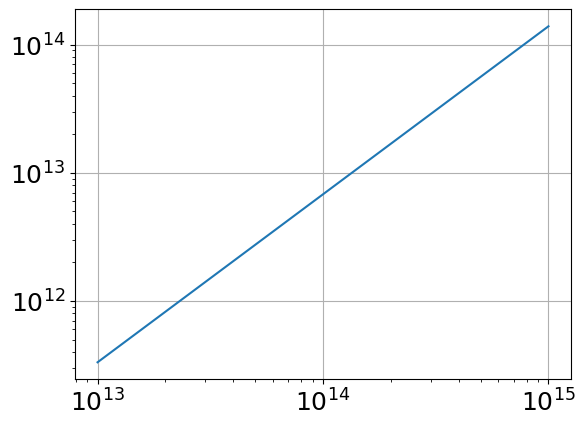

In [149]:
#Dietrich2019: AMg : 0.112 +0.012−0.017; BMg: 1.310 +0.080−0.084; CMg: 0.06 +0.19−0.20; σln Mg: 0.120 +0.044−0.039
#function: M_gas/(5e14 Msun) = A*(M500/5e14)^B * (E(Z)/E(0.6))^C with E(Z)=H(Z)/H0
m500=10**np.arange(13,15.2,0.2)
mg=5e14*0.112*(m500/5e14)**1.31*(cosm.H0/cosm.H(0.6))**0.06
plot(m500,mg/(cosm.H0/cosm.H(0.6))**0.06)
xscale('log')
yscale('log')
grid()

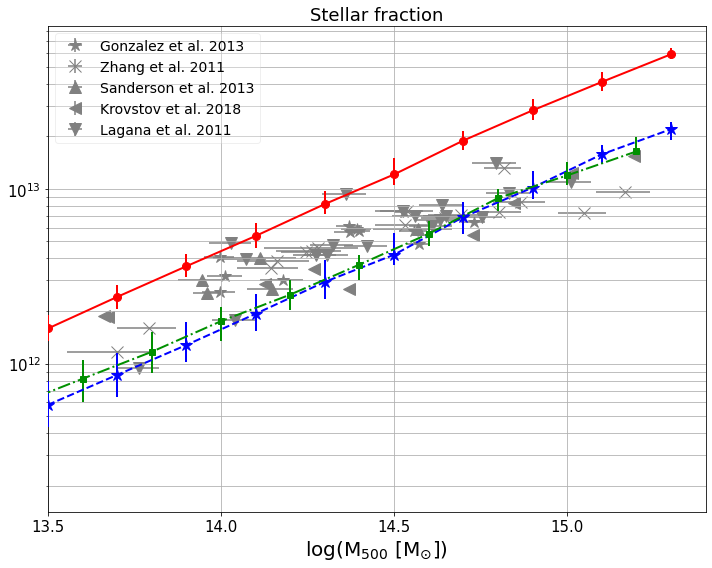

In [11]:
fig=plt.figure(1,figsize=(10,8))
gasylim=[2.0e-2,0.25]
starylim=[5.0e-3,0.09]
mlim=[13.,15.5]
X=np.arange(mlim[0],mlim[1],0.2); xx=(X[1:]+X[:-1])/2
# Y1=np.arange(gasylim[0],gasylim[1],0.005); yy1=(Y1[1:]+Y1[:-1])/2
# Y2=np.arange(starylim[0],starylim[1],0.001); yy2=(Y2[1:]+Y2[:-1])/2
lvsp=0.4
nbn=X
nbnz=X-0.1;xxz=xx-0.1

x=np.log10(Music[:,9]*1.0e10/0.6777)
myp=Music[:,12]*10**x
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 86), bins=nbn)
errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='o',color=safecolor['red'],lw=2, ls="-", ms=8,zorder=8)
# np.savetxt('figdata/BF-star-MUSIC-figure.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_star, f_l, f_u')

x=np.log10(G3X[:,12]*1.0e10/0.6777)
myp=G3X[:,15]*10**x
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbn)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 86), bins=nbn)
errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='*',color=safecolor['blue'],lw=2,ls="--", ms=12,zorder=8)
# np.savetxt('figdata/BF-star-G3X-figure.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_star, f_l, f_u')

x=np.log10(GIZMO[:,12]/0.6777)
myp=GIZMO[:,15]*10**x
pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbnz)
pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbnz)
pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 86), bins=nbnz)
errorbar(xxz, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
         marker='s',color=safecolor['green'],lw=2,ls="-.", ms=6,zorder=8)
# np.savetxt('figdata/BF-star-GIZMO-figure.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_star, f_l, f_u')

ogzb=errorbar(np.log10(Gon500[:-3]),Gon500[:-3]*Gon13[:-3,4],xerr=np.abs(Gonmerr[:,:-3]),yerr=np.abs(Gon13[:-3,5]),
              fmt='*',c='gray',mec='gray',zorder=-9, label="Gonzalez et al. 2013",ms=12)
ogzb=errorbar(np.log10(Zhang500[:-3]),Zhang500[:-3]*Zhang11[:-3,4],xerr=np.abs(Zhmerr[:,:-3]),yerr=np.abs(Zhang11[:-3,5]),
              fmt='x',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Zhang et al. 2011",ms=12)
ogzs=errorbar(np.log10(Sanderson13[:,0]),Sanderson13[:,0]*Sanderson13[:,4],
              xerr=np.array([[np.log10(Sanderson13[:,0])-np.log10(Sanderson13[:,0]-Sanderson13[:,1])],
                             [-np.log10(Sanderson13[:,0])+np.log10(Sanderson13[:,0]+Sanderson13[:,1])]]).reshape((2,5)),
              yerr=Sanderson13[:,5], fmt='^',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Sanderson et al. 2013",ms=12)
# plot(x*0.6777, 4.0e12*(x/4.8e14)**0.8*(1./1.6)**0.05/x, ':',lw=2,color="#800000", label="Chiu et al. 2017") #
# plot(xx, 10.**((xx-14.5)*0.59+12.71)/10.**(xx), ':',lw=2,color=safecolor['lime'], label="Kravtsov et al. 2018")
ogzs=errorbar(np.log10(Krovstov18[:,0]),(Krovstov18[:,3]+Krovstov18[:,5]),
              yerr=np.array([[(Krovstov18[:,4]+Krovstov18[:,6])/Krovstov18[:,0]],
                             [(Krovstov18[:,4]+Krovstov18[:,6])/Krovstov18[:,0]]]).reshape((2,9)),
              fmt='<',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Krovstov et al. 2018",ms=12)
ogzs=errorbar(np.log10(Lagana11[:,0]),Lagana11[:,0]*Lagana11[:,2],
              xerr=np.array([[np.log10(Lagana11[:,0])-np.log10(Lagana11[:,0]-Lagana11[:,1])],
                             [-np.log10(Lagana11[:,0])+np.log10(Lagana11[:,0]+Lagana11[:,1])]]).reshape((2,19)),
              yerr=np.array([Lagana11[:,3],Lagana11[:,3]]),
              fmt='v',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=12, label='Lagana et al. 2011')
# fill_between(xx, 10.**((xx-14.5)*0.59+12.71+0.11)/10.**(xx), 
#              10.**((xx-14.5)*0.59+12.71-0.11)/10.**(xx), color='0.5', alpha=0.5)
# plot([np.log10(4.6e14/0.6777),np.log10(4.6e14/0.6777)],starylim,'k--',lw=2)
title("Stellar fraction",fontsize=18)
xlabel(r"$\log(\rm{M}_{500} \ [\rm{M}_{\odot}])$",fontsize=20)
# ylim(starylim)

grid(b=True,which='major')
grid(b=True,which='minor')
yscale('log')
legend(loc=2,ncol=1,fontsize=14,markerscale=1,framealpha=0.3,columnspacing=0.1)
xticks(arange(mlim[0],mlim[1],0.5),fontsize=15)
yticks(fontsize=15)
xlim(13.5,15.4)
tight_layout()

# redshift evolution

In [15]:
linestyle_tuple = [
#      ('loosely dotted',        (0, (1, 10))),
#      ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

#      ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

#      ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (6, 5, 1, 5, 1, 5))),
#      ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


In [16]:
def EZ(z):
    return  (0.307115*(1 + z)**3 + (1-0.307115))**0.5

In [23]:
colorcircle=['tab:red','tab:orange','tab:olive','tab:green','tab:cyan','tab:blue','tab:purple']

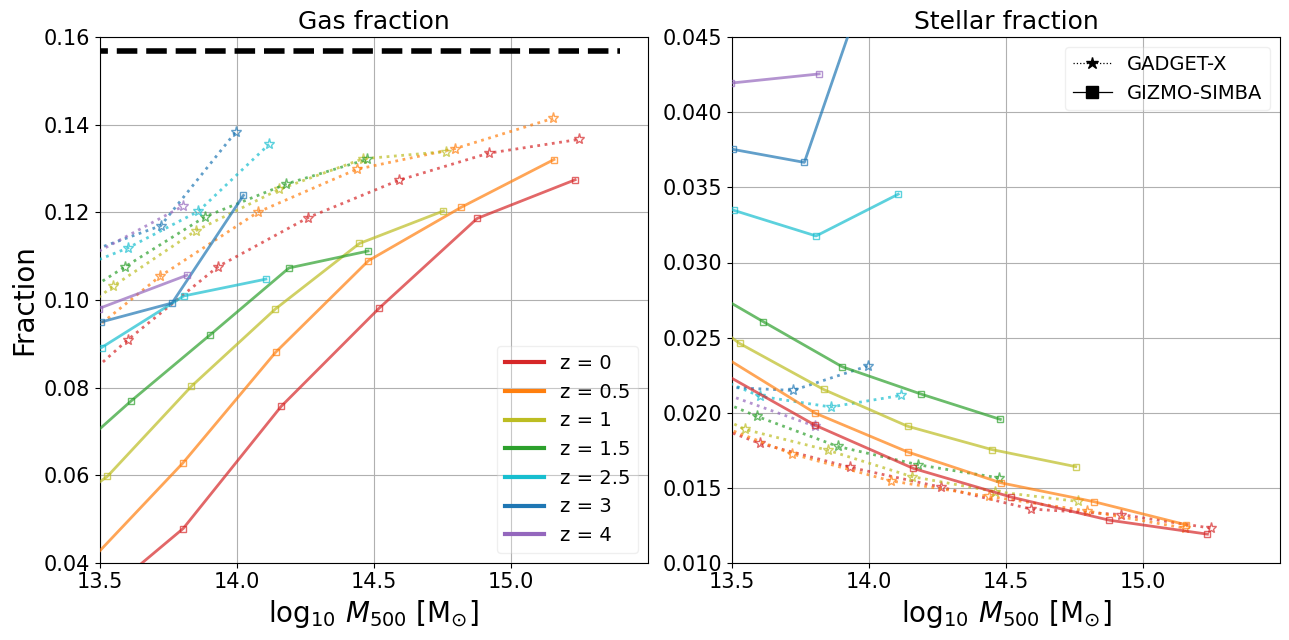

In [46]:
# Plot the data
fig=plt.figure(1,figsize=(13,6.5))
gasylim=[3.0e-2,0.17]
starylim=[0.006,0.052]
mlim=[13.5,15.5]
X=np.arange(12.8,mlim[1],0.2); xx=(X[1:]+X[:-1])/2
# Y1=np.arange(gasylim[0],gasylim[1],0.005); yy1=(Y1[1:]+Y1[:-1])/2
# Y2=np.arange(starylim[0],starylim[1],0.001); yy2=(Y2[1:]+Y2[:-1])/2
lvsp=0.4
nbn=X
nbnz=X-0.1;xxz=xx-0.1

lww=[1,1,1,1,1,1,1]*2

# MUSIC
# for z,visiblen,(lnm,lls) in zip([0,0.5,1,1.5,2.5,3,4],[17,10,7,6,4,3,1],linestyle_tuple):
    # Music = np.load("../Halo_mass_function_mass-difference/MUSIC/Music_Mass_snap_%03d_info.npy" % sn)
    # subplot(121)
    # x=np.log10(Music[:,9]*1.0e10/0.6777*EZ(z))
    # myp=Music[:,11]
    # pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
    # plot(xx,pm,marker='o',color=safecolor['red'],ls=lls,lw=0.9,ms=3,zorder=8)
#     errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
#              marker='o',color=safecolor['red'],lw=2, ls=lls, ms=2,zorder=8, label="GADGET-MUSIC")
    # np.savetxt('figdata/BF-gas-MUSIC-M500.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_gas, f_l, f_u')

    # subplot(122)
    # x=np.log10(Music[:,9]*1.0e10/0.6777*EZ(z))
    # myp=Music[:,12]
    # pm,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbn)
    # plot(xx,pm,marker='o',color=safecolor['red'],ls=lls,lw=0.9,ms=3,zorder=8)
#     errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
#              marker='o',color=safecolor['red'],lw=2, ls=lls, ms=2,zorder=8)

#G3X
for z,sn,cn,lws,(lnm,lls) in zip([0,0.5,1,1.5,2.5,3,4],[128,110,96,87,71,65,55],colorcircle,lww,linestyle_tuple):
    G3X=np.load("../Halo_mass_function_mass-difference/GadgetX/G3X_Mass_snap_%03dinfo.npy" % sn)
    subplot(121)
    x=np.log10(G3X[:,12]*1.0e10/0.6777)  #*EZ(z))
    myp=G3X[:,14]
    nbns=12 #nbn+0.05*lws
    pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbns)
    pm,bem,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbns)
    pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbns)
    xx=(bem[1:]+bem[:-1])/2
    plot(xx,pm,marker='*',color=cn,ls=':',lw=lws*2,alpha=0.7,ms=lws*8,mfc='none',zorder=8)
    # errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
             # marker='*',color=safecolor['red'],ls=lls,lw=lws,alpha=0.7,ms=lws*4,mfc='none',zorder=8) #, label="GADGET-X")
# np.savetxt('figdata/BF-gas-G3X-M500.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_gas, f_l, f_u')
   
    subplot(122)
    x=np.log10(G3X[:,12]*1.0e10/0.6777)  #*EZ(z))
    myp=G3X[:,15]
    pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbns)
    pm,bem,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbns)
    pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 86), bins=nbns)
    xx=(bem[1:]+bem[:-1])/2
    plot(xx,pm,marker='*',color=cn,ls=':',lw=lws*2,alpha=0.7,ms=lws*8,mfc='none',zorder=8)
    # errorbar(xx, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
             # marker='*',color=safecolor['red'],ls=lls,lw=lws,alpha=0.7,ms=lws*4,mfc='none',zorder=8)
    # np.savetxt('figdata/BF-star-G3X-figure.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_star, f_l, f_u')

# GIZMO
for z,sn,cn,lws,(lnm,lls) in zip([0,0.5,1,1.5,2.5,3,4],[128,110,96,87,71,65,55],colorcircle,lww,linestyle_tuple):
    GIZMO=np.load('../Halo_mass_function_mass-difference/GIZMO/GS_Mass_snap_%03dinfo.npy' % sn)
    
    subplot(121)
    x=np.log10(GIZMO[:,12]/0.6777)  #*EZ(z))
    myp=GIZMO[:,14]
    nbns=12 #lws*0.05+nbnz
    pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbns)
    pm,bem,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbns)
    pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 84), bins=nbns)
    xxz=(bem[1:]+bem[:-1])/2
    plot(xxz,pm,marker='s',color=cn,ls='-',lw=lws*2,alpha=0.7,ms=lws*4,mfc='none',zorder=8)
    # errorbar(xxz, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
             # marker='s',color=safecolor['green'],ls=lls,lw=lws,alpha=0.7,ms=lws*2,mfc='none',zorder=8) #,label="GIZMO-SIMBA")
    # np.savetxt('figdata/BF-gas-GIZMO-M500.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_gas, f_l, f_u')

    subplot(122)
    x=np.log10(GIZMO[:,12]/0.6777)  #*EZ(z))
    myp=GIZMO[:,15]
    pl,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 16), bins=nbns)
    pm,bem,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 50), bins=nbns)
    pu,be,bn=bst(x, myp, statistic=lambda y: np.percentile(y, 86), bins=nbns)
    xxz=(bem[1:]+bem[:-1])/2
    # errorbar(xxz, pm, yerr=np.append(pm-pl,pu-pm).reshape(2,pl.size),
             # marker='s',color=safecolor['green'],ls=lls,lw=lws,alpha=0.7,ms=lws*2,mfc='none',zorder=8)
    plot(xxz,pm,marker='s',color=cn,ls='-',lw=lws*2,alpha=0.7,ms=lws*4,mfc='none',zorder=8)
#observational data
# ogzs=errorbar(np.log10(Gon500),Gon13[:,2],xerr=np.abs(Gonmerr),yerr=np.abs(Gon13[:,3]),
#               fmt='*',c='gray',mec='gray',zorder=-9, ms=12)
# ogzs=errorbar(np.log10(Zhang500),Zhang11[:,2],xerr=np.abs(Zhmerr),yerr=np.abs(Zhang11[:,3]),
#               fmt='x',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=12)

# ogzs=errorbar(np.log10(Sanderson13[:,0]),Sanderson13[:,2],
#               xerr=np.array([[np.log10(Sanderson13[:,0])-np.log10(Sanderson13[:,0]-Sanderson13[:,1])],
#                              [-np.log10(Sanderson13[:,0])+np.log10(Sanderson13[:,0]+Sanderson13[:,1])]]).reshape((2,5)),
#               yerr=np.array([Sanderson13[:,3],Sanderson13[:,3]]),
#               fmt='^',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=12)
# ogzs=errorbar(np.log10(Lagana11[:,0]),Lagana11[:,4]-Lagana11[:,2],
#               xerr=np.array([[np.log10(Lagana11[:,0])-np.log10(Lagana11[:,0]-Lagana11[:,1])],
#                              [-np.log10(Lagana11[:,0])+np.log10(Lagana11[:,0]+Lagana11[:,1])]]).reshape((2,19)),
#               yerr=np.array([Lagana11[:,5]-Lagana11[:,3],Lagana11[:,5]-Lagana11[:,3]]),
#               fmt='v',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=12)
# x = 10.**np.arange(13.7,15.6,0.1)
# plot(x*0.6777, 5.69e13*(x/4.8e14)**1.33*(1./1.6)**-0.15/x, ':',zorder=9, color="#800000",lw=2, label="Chiu et al. 2017") # 
subplot(121)

for z,sn,cn,lws,(lnm,lls) in zip([0,0.5,1,1.5,2.5,3,4],[128,110,96,87,71,65,55],colorcircle,lww,linestyle_tuple):
    plot([],[], color=cn,ls='-',label='z = '+str(z), lw=lws*3)

plot([13,15.4],[0.048206/0.307115,0.048206/0.307115],'k--',lw=4)

# plot([np.log10(4.62e14/0.6777),np.log10(4.62e14/0.6777)],gasylim,'k--',lw=2)

xlabel(r"$\log_{10}\ M_{500}\ [\rm{M}_{\odot}]$",fontsize=20)
# yscale('log')
# xscale('log')
grid(visible=True,which='major')
grid(visible=True,which='minor')
ylim([0.04,0.16])  #(gasylim)
xlim([14.5,15.5])
xticks(arange(mlim[0],mlim[1],0.5),fontsize=15)
yticks(fontsize=15)
legend(loc=4,ncol=1,fontsize=14,markerscale=2,framealpha=0.3,columnspacing=0.1) #,fontsize=18
ylabel("Fraction",fontsize=20)
title("Gas fraction",fontsize=18)


subplot(122)

# np.savetxt('figdata/BF-star-GIZMO-figure.txt',np.asarray([xx, pm, pl, pu]).T, header='\log M500 [M_sun], f_star, f_l, f_u')

# ogzb=errorbar(np.log10(Gon500[:-3]),Gon13[:-3,4],xerr=np.abs(Gonmerr[:,:-3]),yerr=np.abs(Gon13[:-3,5]),
#               fmt='*',c='gray',mec='gray',zorder=-9, label="Gonzalez et al. 2013",ms=12)
# ogzb=errorbar(np.log10(Zhang500[:-3]),Zhang11[:-3,4],xerr=np.abs(Zhmerr[:,:-3]),yerr=np.abs(Zhang11[:-3,5]),
#               fmt='x',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Zhang et al. 2011",ms=12)
# ogzs=errorbar(np.log10(Sanderson13[:,0]),Sanderson13[:,4],
#               xerr=np.array([[np.log10(Sanderson13[:,0])-np.log10(Sanderson13[:,0]-Sanderson13[:,1])],
#                              [-np.log10(Sanderson13[:,0])+np.log10(Sanderson13[:,0]+Sanderson13[:,1])]]).reshape((2,5)),
#               yerr=Sanderson13[:,5], fmt='^',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Sanderson et al. 2013",ms=12)
# # plot(x*0.6777, 4.0e12*(x/4.8e14)**0.8*(1./1.6)**0.05/x, ':',lw=2,color="#800000", label="Chiu et al. 2017") #
# # plot(xx, 10.**((xx-14.5)*0.59+12.71)/10.**(xx), ':',lw=2,color=safecolor['lime'], label="Kravtsov et al. 2018")
# ogzs=errorbar(np.log10(Krovstov18[:,0]),(Krovstov18[:,3]+Krovstov18[:,5])/Krovstov18[:,0],
#               yerr=np.array([[(Krovstov18[:,4]+Krovstov18[:,6])/Krovstov18[:,0]],
#                              [(Krovstov18[:,4]+Krovstov18[:,6])/Krovstov18[:,0]]]).reshape((2,9)),
#               fmt='<',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, label="Krovstov et al. 2018",ms=12)
# ogzs=errorbar(np.log10(Lagana11[:,0]),Lagana11[:,2],
#               xerr=np.array([[np.log10(Lagana11[:,0])-np.log10(Lagana11[:,0]-Lagana11[:,1])],
#                              [-np.log10(Lagana11[:,0])+np.log10(Lagana11[:,0]+Lagana11[:,1])]]).reshape((2,19)),
#               yerr=np.array([Lagana11[:,3],Lagana11[:,3]]),
#               fmt='v',c=safecolor['gray'],mec=safecolor['gray'],zorder=-9, ms=12, label='Lagana et al. 2011')
# fill_between(xx, 10.**((xx-14.5)*0.59+12.71+0.11)/10.**(xx), 
#              10.**((xx-14.5)*0.59+12.71-0.11)/10.**(xx), color='0.5', alpha=0.5)
# plot([np.log10(4.6e14/0.6777),np.log10(4.6e14/0.6777)],starylim,'k--',lw=2)
title("Stellar fraction",fontsize=18)
xlabel(r"$\log_{10}\ M_{500}\ [\rm{M}_{\odot}]$",fontsize=20)
ylim(0.01,0.045) #(starylim)
xlim([13.5,15.5])
grid(visible=True,which='major')
grid(visible=True,which='minor')
# yscale('log')
# plot([],[],marker='o',color=safecolor['red'],ls='-',lw=0.9,ms=3,label='GADGET-MUSIC')
plot([],[],marker='*',color=safecolor['black'],ls=':',lw=0.9,ms=3,label='GADGET-X')
plot([],[],marker='s',color=safecolor['black'],ls='-',lw=0.9,ms=3,label='GIZMO-SIMBA')
legend(loc=0,ncol=1,fontsize=14,markerscale=3,framealpha=0.3,columnspacing=0.1)
xticks(arange(mlim[0],mlim[1],0.5),fontsize=15)
yticks(fontsize=15)

tight_layout()
savefig("plots/Baryonic-fractions-redevo.pdf",dpi=300)

In [60]:
bn.shape

(99272,)

# Evolution as a function of redshift for these central cluster/progenitors

(array([ 1.,  1.,  0.,  2.,  4.,  6.,  4.,  5.,  2.,  8.,  3., 13., 11.,
         9., 13., 15., 26., 15., 12., 15., 13., 12.,  8.,  6.,  6.,  8.,
        11.,  9.,  2.,  4.,  8.,  9.,  6.,  3.,  4.,  2.,  5.,  3.,  2.,
         5.,  2.,  1.,  3.,  2.,  5.,  1.,  2.,  2.,  0.,  0.,  0.,  1.,
         1.,  1.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  1.]),
 array([ 37859.43898019,  40075.70196644,  42291.96495269,  44508.22793894,
         46724.49092519,  48940.75391144,  51157.01689769,  53373.27988394,
         55589.54287019,  57805.80585644,  60022.06884268,  62238.33182893,
         64454.59481518,  66670.85780143,  68887.12078768,  71103.38377393,
         73319.64676018,  75535.90974643,  77752.17273268,  79968.43571893,
         82184.69870518,  84400.96169143,  86617.22467

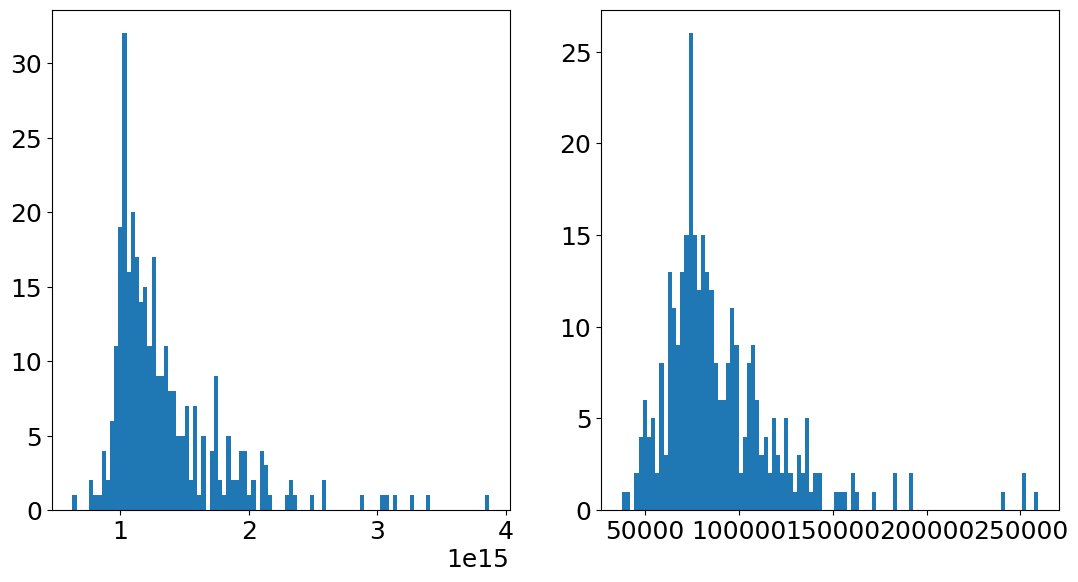

In [26]:
G3xcentral=np.loadtxt('../Halo_mass_function_mass-difference/G3X_Mass_snap_128-center-cluster.txt')
fig=plt.figure(1,figsize=(13,6.5))
subplot(121)
hist(G3xcentral[:,2]/0.6777,bins=100)
subplot(122)
hist(G3xcentral[:,9]/0.6777,bins=100)

In [61]:
len(G3xcentral[G3xcentral[:,9]/0.6777<75000,0]),len(G3xcentral[G3xcentral[:,9]/0.6777>100000,0]),

(114, 86)

In [27]:
GIZcentral=np.loadtxt('../GIZMO/GIZMO-Mass_snap_128-center-cluster.txt')
GIZcentral[0]

array([1.00000000e+00, 1.28000000e+14, 0.00000000e+00, 2.64348000e+15,
       5.00482334e+05, 5.00428437e+05, 5.00475410e+05, 2.24855000e+03,
       9.98322000e-01, 3.49719000e+00, 3.56191000e+14, 2.73277000e+13,
       1.75794875e+15, 1.44538978e+03, 1.35176539e-01, 1.09560704e-02])

In [62]:
len(GIZcentral[GIZcentral[:,12]/0.6777<7.5e14,0]),len(GIZcentral[GIZcentral[:,12]/0.6777>1e15,0]),

(145, 76)

In [39]:
#Get the data -- G3X
if os.path.isfile('data/G3Xevo.npy'):
    G3Xevo=np.load('data/G3Xevo.npy')
else:
    progen=np.loadtxt('../Halo_mass_function_mass-difference/GadgetX/Progenitor-IDs-for-center-cluster.txt',dtype=np.int64)
    print(progen.shape)
    G3Xevo=np.zeros((progen.shape[0],progen.shape[1],3))-1
    for i in np.arange(25,129):
        G3X=np.load("../Halo_mass_function_mass-difference/GadgetX/G3X_Mass_snap_%03dinfo.npy" % i)
        G3Xhids=np.int64(G3X[:,1]+0.1)
        for j in range(324):
            if progen[j,i]>1:
                sid=(G3Xhids==progen[j,i])&(G3X[:,0]==j+1)
                if len(G3Xhids[sid]) != 1:
                    print("Must be an error at", i, j, len(G3Xhids[sid]))
                else:
                    G3Xevo[j,i,:]=[G3X[sid,14],G3X[sid,15],G3X[sid,12]*1.0e10/0.6777]
    np.save('data/G3Xevo.npy',G3Xevo)

In [40]:
# get median lines
G3Cme=np.zeros((3,129,3))
idl=G3Xevo[:,-1,2]<=7.5e14
idm=(G3Xevo[:,-1,2]>7.5e14)&(G3Xevo[:,-1,2]<=1e15)
idh=G3Xevo[:,-1,2]>1e15
for i in np.arange(25,129):
    ids=G3Xevo[idl,i,2]>0
    G3Cme[0,i,:]=[np.median(G3Xevo[idl,i,0][ids]),np.median(G3Xevo[idl,i,1][ids]),np.median(G3Xevo[idl,i,2][ids])]
    ids=G3Xevo[idm,i,2]>0
    G3Cme[1,i,:]=[np.median(G3Xevo[idm,i,0][ids]),np.median(G3Xevo[idm,i,1][ids]),np.median(G3Xevo[idm,i,2][ids])]
    ids=G3Xevo[idh,i,2]>0
    G3Cme[2,i,:]=[np.median(G3Xevo[idh,i,0][ids]),np.median(G3Xevo[idh,i,1][ids]),np.median(G3Xevo[idh,i,2][ids])]

In [37]:
#Get the data -- GIZMO
if os.path.isfile('data/GIZevo.npy'):
    GIZevo=np.load('data/GIZevo.npy')
else:
    progen=np.loadtxt('../Halo_mass_function_mass-difference/GIZMO/Progenitor-IDs-for-center-cluster.txt',dtype=np.int64)
    print(progen.shape)
    GIZevo=np.zeros((progen.shape[0],progen.shape[1],3))-1
    for i in np.arange(25,129):
        GIZ=np.load('../Halo_mass_function_mass-difference/GIZMO/GS_Mass_snap_%03dinfo.npy' % i)
        GIZhids=np.int64(GIZ[:,1]+0.1)
        for j in range(324):
            if progen[j,i]>1:
                sid=(GIZhids==progen[j,i])&(GIZ[:,0]==j+1)
                if len(GIZhids[sid]) != 1:
                    print("Must be an error at", i, j, len(GIZhids[sid]))
                else:
                    GIZevo[j,i,:]=[GIZ[sid,14],GIZ[sid,15],GIZ[sid,12]/0.6777]
    np.save('data/GIZevo.npy',GIZevo)

In [38]:
# get median lines
GZCme=np.zeros((3,129,3))
idl=GIZevo[:,-1,2]<=7.5e14
idm=(GIZevo[:,-1,2]>7.5e14)&(GIZevo[:,-1,2]<=1e15)
idh=GIZevo[:,-1,2]>1e15
for i in np.arange(25,129):
    ids=GIZevo[idl,i,2]>0
    GZCme[0,i,:]=[np.median(GIZevo[idl,i,0][ids]),np.median(GIZevo[idl,i,1][ids]),np.median(GIZevo[idl,i,2][ids])]
    ids=GIZevo[idm,i,2]>0
    GZCme[1,i,:]=[np.median(GIZevo[idm,i,0][ids]),np.median(GIZevo[idm,i,1][ids]),np.median(GIZevo[idm,i,2][ids])]
    ids=GIZevo[idh,i,2]>0
    GZCme[2,i,:]=[np.median(GIZevo[idh,i,0][ids]),np.median(GIZevo[idh,i,1][ids]),np.median(GIZevo[idh,i,2][ids])]

In [34]:
reds=np.loadtxt('../redshifts.txt')

In [35]:
#functions for second axis
from astropy.cosmology import LambdaCDM, z_at_value
import astropy.units as u
cosm=LambdaCDM(Om0=0.307,Ode0=0.693,H0=67.7)
uniage=cosm.age(0).value
def age2red(x):
    if isinstance(x, (list,np.ndarray)):
        rearr=np.copy(x)
        rearr[x<0.0006]=1.0e3
        rearr[x>13.863]=0
        ids=np.where((x>0.0006)&(x<13.863))[0]
        for i in ids:
            rearr[i]=z_at_value(cosm.age, x[i] * u.Gyr)
        return rearr
    else:
        return z_at_value(cosm.age, x * u.Gyr)
def red2age(x):
    if isinstance(x, (list,np.ndarray)):
        rearr=np.copy(x)
        for i in range(len(x)):
            rearr[i]=cosm.age(x[i]).value
        return rearr
    else:
        return cosm.age(x).value

uni_a=cosm.age(reds[:,2]).value ##in Gyr, all sims should be the same
uni_a

array([ 0.22789784,  0.25855586,  0.26591021,  0.27347366,  0.28522398,
        0.29333657,  0.30167981,  0.31464148,  0.32359036,  0.33749294,
        0.34709139,  0.35696268,  0.3722981 ,  0.38288573,  0.39377426,
        0.41068992,  0.4223685 ,  0.43437884,  0.45303712,  0.46591865,
        0.48593012,  0.49974583,  0.51395385,  0.53602575,  0.55126366,
        0.56693412,  0.59127765,  0.60808349,  0.62976295,  0.64766057,
        0.67074803,  0.69465652,  0.71941516,  0.7398542 ,  0.76621923,
        0.79352104,  0.82179236,  0.84513051,  0.87523399,  0.90640553,
        0.93868246,  0.96532596,  0.99969117,  1.0352735 ,  1.06464416,
        1.10252497,  1.14174536,  1.18235148,  1.21586647,  1.25908898,
        1.30383559,  1.35015848,  1.38838806,  1.43768584,  1.48871528,
        1.54153553,  1.58512171,  1.64131909,  1.69357498,  1.75356185,
        1.80933642,  1.87335617,  1.932874  ,  1.99424703,  2.0646812 ,
        2.1375489 ,  2.2052756 ,  2.27509533,  2.35520019,  2.42

In [98]:
age2red(1)

5.703542530880663

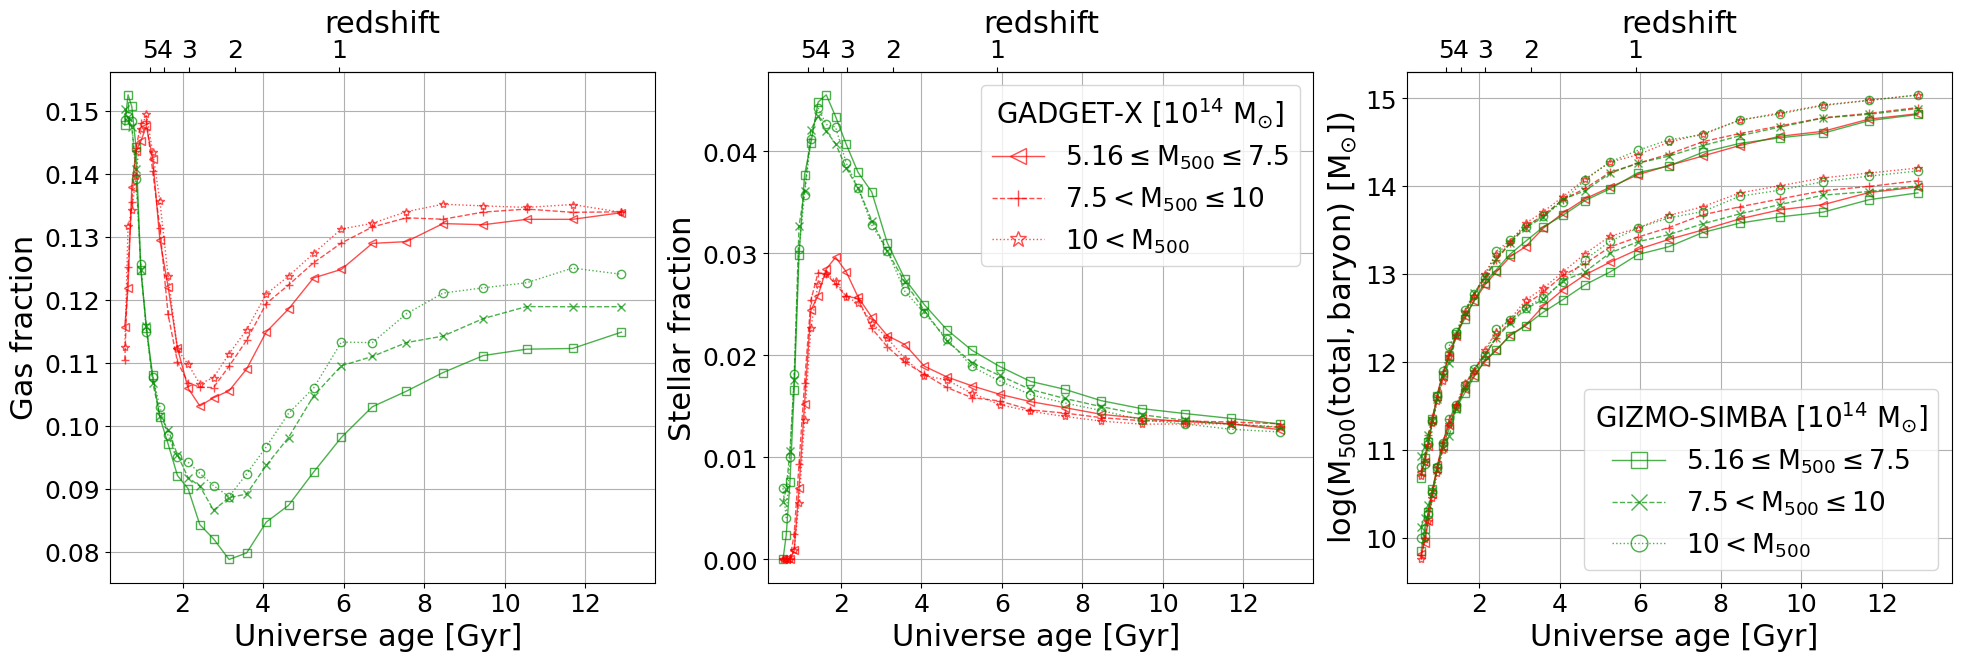

In [41]:
# Plot the data
fig, (ax1,ax2,ax3) = subplots(1,3,constrained_layout=True,figsize=(19.5,6.5))

gasylim=[2.0e-2,0.25]
starylim=[5.0e-3,0.09]
mlim=[13.,15.5]
X=np.arange(mlim[0],mlim[1],0.2); xx=(X[1:]+X[:-1])/2

lvsp=0.4
nbn=X
nbnz=X-0.1;xxz=xx-0.1

# Gas 
#  G3X
for i,lls,ms1,ms2,lbl in zip(range(3),['-','--',':'],['<','+','*'],['s','x','o'],[r'$5.16 \leq \rm{M}_{500} \leq 7.5$',r'$7.5 < \rm{M}_{500} \leq 10$',r'$10 < \rm{M}_{500}$']):
    ax1.plot(uni_a[25:][::4], G3Cme[i,25:,0][::4],marker=ms1,color=safecolor['red'],ls=lls,lw=1,alpha=0.7,ms=6,mfc='none',zorder=8)
    ax1.plot(uni_a[25:][::4], GZCme[i,25:,0][::4],marker=ms2,color=safecolor['green'],ls=lls,lw=1,alpha=0.7,ms=6,mfc='none',zorder=8)

    ax2.plot(uni_a[25:][::4], G3Cme[i,25:,1][::4],marker=ms1,color=safecolor['red'],ls=lls,lw=1,alpha=0.7,ms=6,mfc='none',zorder=8,label=lbl)
    ax2.plot(uni_a[25:][::4], GZCme[i,25:,1][::4],marker=ms2,color=safecolor['green'],ls=lls,lw=1,alpha=0.7,ms=6,mfc='none',zorder=8)
    
    ax3.plot(uni_a[25:][::4], np.log10(G3Cme[i,25:,2])[::4],marker=ms1,color=safecolor['red'],ls=lls,lw=1,alpha=0.7,ms=6,mfc='none',zorder=8)
    ax3.plot(uni_a[25:][::4], np.log10(GZCme[i,25:,2])[::4],marker=ms2,color=safecolor['green'],ls=lls,lw=1,alpha=0.7,ms=6,mfc='none',zorder=8,label=lbl)

    ax3.plot(uni_a[25:][::4], np.log10(G3Cme[i,25:,2]*(G3Cme[i,25:,1]+G3Cme[i,25:,0]))[::4],marker=ms1,color=safecolor['red'],ls=lls,lw=1,alpha=0.7,ms=6,mfc='none',zorder=8)
    ax3.plot(uni_a[25:][::4], np.log10(GZCme[i,25:,2]*(GZCme[i,25:,1]+GZCme[i,25:,0]))[::4],marker=ms2,color=safecolor['green'],ls=lls,lw=1,alpha=0.7,ms=6,mfc='none',zorder=8)
a2l=ax2.legend(loc=0,ncol=1,fontsize=19,markerscale=2,framealpha=0.8,columnspacing=0.1,title=r'GADGET-X $[10^{14} \ \rm{M}_{\odot}]$')
a3l=ax3.legend(loc=0,ncol=1,fontsize=19,markerscale=2,framealpha=0.8,columnspacing=0.1,title=r'GIZMO-SIMBA [$10^{14} \ \rm{M}_{\odot}]$')

setp(a2l.get_title(),fontsize=20)
setp(a3l.get_title(),fontsize=20)

[axs.set_xlim(0.2,uniage-0.1) for axs in [ax1, ax2, ax3]]
[axs.grid() for axs in [ax1, ax2, ax3]]

secaxy = ax1.secondary_xaxis('top', functions=(age2red, red2age))
secaxy.set_xlabel(r'redshift',fontsize=22)
# secaxy.xaxis.set_major_formatter(ScalarFormatter())
# secaxy.minorticks_on()
secaxy.set_xticks([1,2,3,4,5,6,8,10])


secaxy1 = ax2.secondary_xaxis('top', functions=(age2red, red2age))
secaxy1.set_xlabel(r'redshift',fontsize=22)
secaxy1.set_xticks([1,2,3,4,5,6,8,10])

secaxy2 = ax3.secondary_xaxis('top', functions=(age2red, red2age))
secaxy2.set_xlabel(r'redshift',fontsize=22)
secaxy2.set_xticks([1,2,3,4,5,6,8,10])

# xlim(1,uniage)
# ylim(6,12.7)
[axs.set_xlabel(r'Universe age [Gyr] ',fontsize=22) for axs in [ax1,ax2,ax3]]
ax1.set_ylabel(r'Gas fraction',fontsize=22)
ax2.set_ylabel(r'Stellar fraction',fontsize=22)
ax3.set_ylabel(r'$\log(\rm{M}_{500} (total, baryon)  \ [\rm{M}_{\odot}])$',fontsize=22)
# ax3.set_yscale('log')
# tight_layout()
savefig("plots/Evo-CC-BF.pdf",dpi=300)